# Assignment 3: SOM - implementation option

<font size="4">**Group 03**
</font>


<font size="5">**Visualization group a:**
</font>

<font size="4">In this notebook we implement the following 5 visualizations:
* DMat+PMat+U*Mat (UMatrix reused from the template provided)
* qe, mqe
</font>

<br>

Proceed to [Evaluation report](#EvaluationReport)

# Implementation part

In this part we implement the visualizations described above.

We reuse the the class **SOMToolBox_Parse** as implemented in the provided template and we append to the class **SomViz**  the new methods required for plotting the 5 new visualization options

In [1]:
#Imports used throught this notebook
import gzip

import numpy as np
import plotly.graph_objects as go
from IPython.core.display import display, HTML
from ipywidgets import HBox, VBox, Layout, Label
from scipy.spatial import distance_matrix
import pandas as pd
import minisom as som
from sklearn import datasets, preprocessing

display(HTML("<style>.container { width:100% !important; }</style>"))


import pandas as pd
import minisom as som
from sklearn import datasets, preprocessing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import re
import copy

The **SOMToolBox_Parse** class used to parse both input and weight files. No changes were made.

In [2]:
class SOMToolBox_Parse:

    def __init__(self, filename):
        self.filename = filename

    def read_weight_file(self,):
        df = pd.DataFrame()
        if self.filename[-3:len(self.filename)] == '.gz':
            with gzip.open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)
        else:
            with open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)

        file.close()
        return df.astype('float64'), vec_dim, xdim, ydim


    def _read_vector_file_to_df(self, df, file):
        xdim, ydim, vec_dim, position = 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, vec_dim = self._parse_vector_file_metadata(line, xdim, ydim, vec_dim)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim * xdim), columns=range(0, vec_dim))
            else:
                if len(df.columns) == 0 or vec_dim == 0:
                    raise ValueError('Weight file has no correct Dimensional information.')
                position = self._parse_weight_file_data(line, position, vec_dim, df)
        return df, vec_dim, xdim, ydim


    def _parse_weight_file_data(self, line, position, vec_dim, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[0:vec_dim]).astype(float))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.')
        return  position


    def _parse_vector_file_metadata(self, line, xdim, ydim, vec_dim):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$VEC_DIM': vec_dim = int(splitted[1])
        return xdim, ydim, vec_dim

The **SomViz** class. As requested we extended this class to also support the creation of visualizations for the following:
- D-matrix
- P-matrix
- U\*-matrix
- qe (quantization error)
- mqe (mean quantization error)

This class contains methods for both plotting or obtaining the underlying matrix. For example, "plot_mean_quantization_error()" will plot the mqe while "calculate_mean_quantization_errors()" will return a matrix with the mqe.

Since the provided U-matrix implementation deviated from the one in SOMToolbox and contained a bug (where it considered the distance to itself in the calculation of the mean) we decided to implement a new U-matrix in order for our U\*-matrix to be consistent with SOMToolbox. This implementation uses the median (as opposed to the mean). Also, we do not implement the interpolating units as they are not used in the calculation of the U\*-matrix.

The unchanged areas have been delimited with a comment so that it is easier to identify the code that we have contributed.

In [3]:
class SomViz:

    def __init__(self, weights=[], m=None, n=None, input_data=[], set_name=""):
        self.weights = weights
        self.input_data = input_data # new parameter
        self.m = m
        self.n = n
        self.set_name = set_name

####################################
######### UNCHANGED SECTION ########
####################################

    def umatrix(self, som_map=None, color="Viridis", interp = "best", title=""):
        um =np.zeros((self.m *self.n, 1))
        neuron_locs = list()
        for i in range(self.m):
            for j in range(self.n):
                neuron_locs.append(np.array([i, j]))
        neuron_distmat = distance_matrix(neuron_locs,neuron_locs)

        for i in range(self.m * self.n):
            neighbor_idxs = neuron_distmat[i] <= 1
            neighbor_weights = self.weights[neighbor_idxs]
            um[i] = distance_matrix(np.expand_dims(self.weights[i], 0), neighbor_weights).mean()

        if som_map==None: return self.plot(um.reshape(self.m,self.n), color=color, interp=interp, title=title)
        else: som_map.data[0].z = um.reshape(self.m,self.n)

    def hithist(self, som_map=None, idata = [], color='RdBu', interp = "best", title=""):
        hist = [0] *self.n *self.m
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            hist[position] += 1

        if som_map==None: return self.plot(np.array(hist).reshape(self.m,self.n), color=color, interp=interp, title=title)
        else:  som_map.data[0].z = np.array(hist).reshape(self.m,self.n)

    def component_plane(self, som_map=None, component=0, color="Viridis", interp = "best", title=""):
        if som_map==None: return self.plot(self.weights[:,component].reshape(-1,self.n), color=color, interp=interp, title=title)
        else:  som_map.data[0].z = self.weights[:,component].reshape(-1,n)

    def sdh(self, som_map=None, idata=[], sdh_type=1, factor=1, draw=True, color="Cividis", interp = "best", title=""):

        import heapq
        sdh_m = [0] *self.m *self.n

        cs=0
        for i in range(0,factor): cs += factor-i

        for vector in idata:
            dist = np.sqrt(np.sum(np.power(self.weights - vector, 2), axis=1))
            c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
            if (sdh_type==1):
                for j in range(0,factor):  sdh_m[c[j]] += (factor-j)/cs # normalized
            if (sdh_type==2):
                for j in range(0,factor): sdh_m[c[j]] += 1.0/dist[c[j]] # based on distance
            if (sdh_type==3):
                dmin = min(dist)
                for j in range(0,factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(max(dist)-dmin)

        if som_map==None: return self.plot(np.array(sdh_m).reshape(-1,self.n), color=color, interp=interp, title=title)
        else: som_map.data[0].z = np.array(sdh_m).reshape(-1,self.n)

    def project_data(self,som_m=None, idata=[], title=""):

        data_y = []
        data_x = []
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            x,y = position % self.n, position // self.n
            data_x.extend([x])
            data_y.extend([y])

        if som_m!=None: som_m.add_trace(go.Scatter(x=data_x, y=data_y, mode = "markers", marker_color='rgba(255, 255, 255, 0.8)',))

    def time_series(self, som_m=None, idata=[], wsize=50, title=""): #not tested

        data_y = []
        data_x = [i for i in range(0,len(idata))]

        data_x2 = []
        data_y2 = []

        qmin = np.Inf
        qmax = 0

        step=1

        ps = []
        for v in idata:
            matrix = np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1))
            position = np.argmin(matrix)
            qerror = matrix[position]
            if qmin>qerror: qmin = qerror
            if qmax<qerror: qmax = qerror
            ps.append((position, qerror))

        markerc=[]
        for v in ps:
            data_y.extend([v[0]])
            rez = v[1]/qmax

            markerc.append('rgba(0, 0, 0, '+str(rez)+')')

            x,y = v[0] % self.n, v[0] // self.n
            if    x==0: y = np.random.uniform(low=y, high=y+.1)
            elif  x==self.m-1: y = np.random.uniform(low=y-.1, high=y)
            elif  y==0: x = np.random.uniform(low=x, high=x+.1)
            elif  y==self.n-1: x = np.random.uniform(low=x-.1, high=x)
            else: x,y = np.random.uniform(low=x-.1, high=x+.1), np.random.uniform(low=y-.1, high=y+.1)

            data_x2.extend([x])
            data_y2.extend([y])

        ts_plot = go.FigureWidget(go.Scatter(x=[], y=[], mode = "markers", marker_color=markerc, marker=dict(colorscale='Viridis', showscale=True, color=np.random.randn(500))))
        ts_plot.update_xaxes(range=[0, wsize])


        ts_plot.data[0].x, ts_plot.data[0].y = data_x, data_y
        som_m.add_trace(go.Scatter(x=data_x2, y=data_y2, mode = "markers",))

        som_m.layout.height = 500
        ts_plot.layout.height = 500
        som_m.layout.width = 500
        ts_plot.layout.width = 1300

        return HBox([go.FigureWidget(som_m), go.FigureWidget(ts_plot)])

    def plot(self, matrix, color="Viridis", interp = "best", title=""):
        return go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color), layout=go.Layout(width=700, height=700,title=title, title_x=0.5,))

####################################
##### END OF UNCHANGED SECTION #####
####################################

    def __flatten_distance_matrix(self, distance_matrix_2d):
        flattened_distances = []

        for idx in range(0, distance_matrix_2d.shape[0] - 1):
            # we need only a partial slice since the distance matrix is symmetrical
            partial_slice = distance_matrix_2d[idx, idx+1:].tolist()

            # concatenate to the already existing
            flattened_distances = flattened_distances + partial_slice

        return flattened_distances

    def __create_percentiles(self, distances):
        flattened_distances = self.__flatten_distance_matrix(distances)
        percentile_range = range(1, 101) # same percentile range as SOM Toolbox
        percentiles = np.percentile(flattened_distances, percentile_range)

        return percentiles

    def __get_all_densities(self, distances, radius):
        rows = distances.shape[0]
        columns = distances.shape[1]

        result = np.zeros(rows)
        for row in range(0, rows):
            counter = 0
            for col in range(row, columns):
                distance = distances[row, col]
                if distance < radius:
                    counter = counter + 1

            result[row] = counter

        return result

    # Taken and converted from SOM Toolbox
    def __calculate_optimal_pareto_radius_percentile(self, input_distances, percentiles):
        #pareto-optimal size, as derived in the paper "Maps for the Visualization of high-dimensional Data Space"
        pareto_size = 0.2013

        # the paper describes the 18th percentile as a good start value for gaussian distributions
        percentile = 18
        radius = 0.0
        last_percentile = percentile
        diff = 0.0
        last_diff = 1.0
        median_size = 0.0
        stop = False
        upper_size = 1.0
        lower_size = 0.0

        # upper and lower search boundaries for the percentiles
        upper_percentile = 50
        lower_percentile = 2

        while not stop:
            # get current radius from the percentile
            radius = percentiles[percentile]

            # compute densities with this radius
            densities = self.__get_all_densities(input_distances, radius)

            len_densities = densities.shape[0]
            if len_densities:
                median = np.median(densities)
                mean = np.sum(densities) / len_densities
                #print("Mean: " + str(mean) + " median: " + str(median))
                median_size = max(median, mean) / input_distances.shape[1]
            else:
                median_size = 0

            #print("spheres for " + str(percentile) + "%-tile contain on average " + str(round(median_size * 100)) + "% of the data")

            diff = median_size - pareto_size

            # stop if last step was 1, or the defined upper/lower stopping criterion is reached
            stop = (abs(percentile - last_percentile) == 1) \
                   or (percentile == upper_percentile) \
                   or (percentile == lower_percentile)

            if not stop: # iterate
                last_percentile = percentile
                last_diff = diff

                # adjust percentile towards optimum with linear interpolation
                if diff > 0:
                    upper_percentile = percentile
                    upper_size = median_size
                else:
                    lower_percentile = percentile
                    lower_size = median_size

                # compute the estimated position of pareto size in the current search interval
                pest = (pareto_size - lower_size) / (upper_size - lower_size) \
                              * (upper_percentile - lower_percentile) + lower_percentile

                # step towards the estimated position
                step = pest - percentile

                # always go at least 1 resp. -1
                if step > 0:
                    step = max(step, 1)
                else:
                    step = min(step, -1)

                percentile = percentile + int(round(step))
            else:
                # if it is better, revert to the last percentile before we stopped
                if abs(diff) > abs(last_diff):
                    percentile = last_percentile

        #print("P-Matrix: " + str(percentile) + "%tile chosen.")
        return percentile

    def p_matrix(self, radius=None):
        if not radius:
            distances = distance_matrix(self.input_data, self.input_data)
            radius_by_percentiles = self.__create_percentiles(distances)
            optimal_percentile = self.__calculate_optimal_pareto_radius_percentile(distances, radius_by_percentiles)
            radius = radius_by_percentiles[optimal_percentile]

        som_to_input_distances = distance_matrix(self.weights, self.input_data)

        # our p-matrix density is the number of inputs whose distance is within the specified radius
        p_matrix = np.count_nonzero(som_to_input_distances < radius, axis=1)

        return p_matrix.reshape(self.m, self.n)

    def __create_neuron_coordinate_matrix(self):
        # Here we create a simple neuron coordinate matrix based on our size (m, n)
        neuron_locs = list()
        for x in range(self.m):
            for y in range(self.n):
                neuron_locs.append(np.array([x, y]))

        return neuron_locs

    def __calculate_neuron_dist_matrix(self):
        # This function is used to calculate neuron distances (not weight distances)
        neuron_locs = self.__create_neuron_coordinate_matrix()
        return distance_matrix(neuron_locs, neuron_locs)

    def __neighbour_distances_based_matrix(self, f_on_neighbors_dist):
        n_matrix = np.zeros((self.m * self.n, 1))
        neuron_dist_mat = self.__calculate_neuron_dist_matrix()

        for i in range(self.m * self.n):
            # we check only immediate neighbours in Von Neumann neighborhood
            neighbor_idxs = neuron_dist_mat[i] == 1
            neighbor_weights = self.weights[neighbor_idxs]

            # calculate weight distances to all our neighbours
            weight_distances = distance_matrix(neighbor_weights, np.expand_dims(self.weights[i], axis=0))

            # apply the function on neighbour weights
            n_matrix[i] = f_on_neighbors_dist(weight_distances)

        return n_matrix.reshape(self.m, self.n)

    def d_matrix(self):
        # D matrix takes the mean of the neighbour distances
        f_on_neighbour_distances = lambda w: w.mean()
        d_matrix = self.__neighbour_distances_based_matrix(f_on_neighbour_distances)

        return d_matrix

    # Create a u-matrix without interpolating units
    def u_matrix(self):
        # SOMToolbox uses the median for non-interpolating units
        f_on_neighbour_distances = lambda w: np.median(w)
        u_matrix = self.__neighbour_distances_based_matrix(f_on_neighbour_distances)

        return u_matrix

    def u_star_matrix(self, p_radius=None):
        p_matrix = self.p_matrix(radius=p_radius)
        u_matrix = self.u_matrix()

        # implementation similar to SOM toolbox
        # first we transform the values of the P-Matrix to a value we can then
        # multiply by the U-Matrix
        p_mean = np.mean(p_matrix)
        p_max = np.max(p_matrix)
        diff = p_mean - p_max

        p_transformation = lambda x: (x - p_mean) / diff + 1
        p_matrix_transformed = p_transformation(p_matrix)

        # finally our U*-Matrix is the multiplication of our U and transformed P matrix
        u_star_matrix = np.multiply(u_matrix, p_matrix_transformed)

        return u_star_matrix

    def __sum_quantization_errors(self):
        # This is a helper function that allows us to calculate both qe and mqe
        # To this end we calculate the qe and store the number of inputs
        # that were mapped to a particular unit

        # First we need to calculate distances to inputs
        input_to_som_distances = distance_matrix(self.input_data, self.weights)
        # Now find out the BMUS per input
        input_bmus = np.argmin(input_to_som_distances, axis=1)
        # Initialize the qe
        sum_quantization_error = np.zeros((self.m * self.n, 2))

        # Iterate over all inputs
        for idx in range(input_bmus.shape[0]):
            # get the BMU for this input
            bmu = input_bmus[idx]
            # calculate the qe
            qe = input_to_som_distances[idx, bmu]
            # add it to the existing qe for its BMU
            qe += sum_quantization_error[bmu, 0]
            # increment the counter of inputs mapped to that unit
            num_inputs_mapped = 1 + sum_quantization_error[bmu, 1]

            # update the qe for that unit
            sum_quantization_error[bmu] = [qe, num_inputs_mapped]

        return sum_quantization_error

    @staticmethod
    def __normalize_1d_matrix(matrix_1d):
        # Normalize a 1D vector by dividing it by its norm
        return matrix_1d / np.linalg.norm(matrix_1d)

    @staticmethod
    def __mask_zero_values(array):
        # Convert all 0 values to NaN (Not a Number)
        array[array == 0] = np.nan
        return array

    def calculate_quantization_error(self):
        qe = self.__sum_quantization_errors()
        qe = self.__normalize_1d_matrix(qe[:, 0])
        qe = self.__mask_zero_values(qe)

        return qe.reshape(self.m, self.n)

    @staticmethod
    def __calculate_mean(sum_qe_tuple):
        qe = sum_qe_tuple[0]
        count = sum_qe_tuple[1]

        mean = (qe/count) if count > 0 else 0.0

        return mean

    def calculate_mean_quantization_errors(self):
        quantization_error = self.__sum_quantization_errors()
        mean_qe = np.apply_along_axis(self.__calculate_mean, 1, quantization_error)

        mean_qe = self.__normalize_1d_matrix(mean_qe)
        mean_qe = self.__mask_zero_values(mean_qe)

        return mean_qe.reshape(self.m, self.n)

    def plot_u_matrix(self, color="Viridis", interp="best"):
        return self.custom_plot(self.u_matrix(), color, interp, title="U-Matrix")

    def plot_d_matrix(self, color="Viridis", interp="best"):
        d_matrix = self.d_matrix()
        return self.custom_plot(d_matrix, color, interp, title="D-Matrix")

    def plot_p_matrix(self, radius=None, color="Viridis", interp="best"):
        p_matrix = self.p_matrix(radius)
        return self.custom_plot(p_matrix, color, interp, title="P-Matrix")

    def plot_u_star_matrix(self, p_radius=None, color="Viridis", interp="best"):
        u_star_matrix = self.u_star_matrix(p_radius=p_radius)
        return self.custom_plot(u_star_matrix, color, interp, title="U*-Matrix")

    def plot_quantization_error(self, color="Viridis", interp="best"):
        qe = self.calculate_quantization_error()
        return self.custom_plot(qe, color, interp, title="Quantization Error")

    def plot_mean_quantization_error(self, color="Viridis", interp="best"):
        mean_qe = self.calculate_mean_quantization_errors()
        return self.custom_plot(mean_qe, color, interp, title="Mean Quantization Error")


    def custom_plot(self, matrix, color="Viridis", interp="best", title=""):
        title = self.set_name + " " + title
        fig = go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color),
                               layout=go.Layout(title=title, title_x=0.5, ))
        
        # Ensure that the aspect ratio is maintained
        fig.update_yaxes(scaleanchor = "x", scaleratio = 1, showticklabels=False)
        fig.update_xaxes(showticklabels=False)
        fig.update_layout(margin=dict(l=0, r=0, t=50, b=0))

        return fig

Here is part of the original notebook that was given to us. It remains here for legacy reasons and is still functional. If you wish to train your own SOM the next section provides better information.

In [4]:
#############################
######## miniSOM ############1/0
#############################
m=10
n=10

# Pre-processing
iris = datasets.load_iris().data
min_max_scaler = preprocessing.MinMaxScaler()
iris = min_max_scaler.fit_transform(iris)

# Train
s = som.MiniSom(m, n, iris.shape[1], sigma=0.8, learning_rate=0.7)
s.train_random(iris, 10000, verbose=False)

# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,4), m, n)
um1 = viz_miniSOM.umatrix(color='magma', interp='best', title='U-matrix miniSOM')


##########################################
######## read from SOMToolBox ############
##########################################
trainedmap = SOMToolBox_Parse('iris.vec')
idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

smap = SOMToolBox_Parse('iris.wgt.gz')
smap, sdim, smap_x, smap_y = smap.read_weight_file()

# Visualizaton
viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)
um2 = viz_SOMToolBox.umatrix(color='viridis', interp=False, title='U-matrix SOMToolBox')

display(HBox([um1, um2]))

    'data': [{'colorscale': [[0.0, '#000004'], [0.1111111111111111, '#180f3d'],
…

## Train and Visualize a SOM using mini-SOM
In this section we will train a SOM using the mini-som library and then use our visualizations. 

First we define a few helper functions to make it easier to set everything up:

In [5]:
def train_mini_som(data, m, n, learning_rate=0.7, sigma=0.8, random_seed=10, iterations=10000):
    # Mini-som coordinate system and SOMToolbox coordinates are not compatible so transform
    # the mini-som to produce the weights/shape expected by SOMToolbox.
    x = n
    y = m

    # extract the number of features from the data
    num_features = data.shape[1]

    # train the mini-som
    mini_som = som.MiniSom(x, y, num_features, sigma=sigma, learning_rate=learning_rate, random_seed=random_seed)
    mini_som.train_random(data, iterations, verbose=False)

    # shape the weights to the expected format
    weights = mini_som.get_weights().reshape(-1, num_features)

    return weights, num_features, y, x

def load_data_for_mini_som(path_to_input):
    input_reader = SOMToolBox_Parse(path_to_input)
    my_data, dim, data_x, data_y = input_reader.read_weight_file()
    
    # we are only interested in the data
    return my_data

def train_and_create_visualizer(som_name, path_to_input, width, height, 
                                learning_rate=0.7, sigma=0.8, random_seed=10, iterations=10000):
    # load data
    data = load_data_for_mini_som(path_to_input)
    
    # train the mini-som
    weights, sdim, smap_x, smap_y = train_mini_som(
        data.to_numpy(),
        width,
        height,
        learning_rate=learning_rate,
        sigma=sigma,
        random_seed=random_seed,
        iterations=iterations
    )
    
    # create the visualizer
    visualizer = SomViz(weights, smap_y, smap_x, data, som_name)
    
    return visualizer

Now we train and create our visualizer.

In [6]:
mini_som_viz = train_and_create_visualizer("Mini-SOM 10 clusters 40x20", # name of our SOM
                                           "data/10clusters/10clusters.vec", # path to input
                                           40, 20, # width and height of our SOM
                                           learning_rate=0.7,
                                           sigma=3,
                                           random_seed=10,
                                           iterations=10000) # change this for example to 100000

Now we can visualize the data. Here are the different visualizations:

In [7]:
display(mini_som_viz.plot_d_matrix(interp=False))
display(mini_som_viz.plot_p_matrix(interp=False))
display(mini_som_viz.plot_u_star_matrix(interp=False))
display(mini_som_viz.plot_quantization_error(interp=False))
display(mini_som_viz.plot_mean_quantization_error(interp=False))

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

FigureWidget({
    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
               …

## Load pre-trained SOMs for comparison
On this section we load a few SOMs that we trained using Java SOMToolBox. The datasets are **Chainlink** and **10 Gaussians** where we trained two SOMs for each of sizes 40x20 and 100x60.

First a few helper functions:

In [8]:
def load_data(set_name):
    file_path = "data/" + set_name + "/" + set_name + ".vec"
    trainedmap = SOMToolBox_Parse(file_path)
    idata, idim, idata_x, idata_y = trainedmap.read_weight_file()

    return idata, idim, idata_x, idata_y

def load_trained_weights(set_name, size):
    file_path = "data/" + set_name + "/maps_" + size + "/" + set_name + ".wgt.gz"
    smap = SOMToolBox_Parse(file_path)
    smap, sdim, smap_x, smap_y = smap.read_weight_file()

    # transform smap to expected weight array
    weights = smap.values.reshape(-1, sdim)

    return weights, sdim, smap_x, smap_y

def create_visualization_for(data, set_name, size):
    # Load weights and create a visualization handler for them
    weights, sdim, smap_x, smap_y = load_trained_weights(set_name, size)
    return SomViz(weights, smap_y, smap_x, data, set_name + " " + size)

And finally load the data and create the visualizing objects for each SOM.

In [9]:
size40x20 = "40x20"
size100x60 = "100x60"
clusters10 = "10clusters"
chainlink = "chainlink"

# Load 10 clusters data & trained SOMs
clusters10_data, idim, idata_x, idata_y = load_data(clusters10)
clusters10_40x20_vis = create_visualization_for(clusters10_data, clusters10, size40x20)
clusters10_100x60_vis = create_visualization_for(clusters10_data, clusters10, size100x60)

# Load chainlink data & trained SOM
chainlink_data, idim, idata_x, idata_y = load_data(chainlink)
chainlink_40x20_vis = create_visualization_for(chainlink_data, chainlink, size40x20)
chainlink_100x60_vis = create_visualization_for(chainlink_data, chainlink, size100x60)

Here some example visualizations are displayed

In [10]:
visualizations = [
    clusters10_40x20_vis.plot_p_matrix(0.04, interp=False),
    clusters10_100x60_vis.plot_p_matrix(0.05, interp=False),
    chainlink_40x20_vis.plot_p_matrix(0.05, interp=False),
    chainlink_100x60_vis.plot_p_matrix(0.05, interp=False),
]

display(VBox(visualizations))

    'data': [{'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
…

### Load custom SOM
If you want to load a custom SOM you can follow these steps:

In [11]:
# if you want to load a custom SOM, change this to True
LoadCustomSOM = False

if LoadCustomSOM:
    # first load the input data (we need this to calculate the P and U* matrix)
    input_reader = SOMToolBox_Parse("path/to/input.vec")
    my_data, dim, data_x, data_y = input_reader.read_weight_file()

    # read the som map from pre-trained SOM
    smap = SOMToolBox_Parse("path/to/weights.wgt.gz")
    smap, sdim, smap_x, smap_y = smap.read_weight_file()

    # reshape the som map and create our visualizer
    weights = smap.values.reshape(-1,sdim)
    my_som_visualizer = SomViz(weights, smap_y, smap_x, my_data, "SOM name")

And to visualize it:

In [12]:
if LoadCustomSOM:
    display(my_som_visualizer.plot_p_matrix(interp=False))

## We now create all visualizations for 10 Clusters and Chainlink datasets and save them for later usage

It would be suggested to skip this block, as all necessary visualizations are displayed in Evaluation part.

In [13]:
# this function is used to save all visualizations as png
def save_plots_for_SOM(dataset, size, visualizations):
    path="images/"+dataset+"/"+size+"/"
    
    for fig in visualizations:
        filename = fig["layout"]["title"]["text"]
        filename=re.sub("\*", 'star', filename)
        filename=re.sub(dataset+" "+size+" ", '', filename)
        temp = copy.copy(fig)
        temp["layout"]["title"]["text"]=None
        temp.write_image(path+"python/"+filename+".png")

filenames=['D-Matrix', 'P-Matrix', 'Ustar-Matrix', 'Quantization Error', 'Mean Quantization Error']

Create all plots for 10 clusters dataset (40x20 and 100x60 SOMs)

In [14]:
# Plot the different visualizations for 10 clusters 40x20 SOM
# the parameters selected here are considered optimal, after trying their different settings
visualizations = [
    clusters10_40x20_vis.plot_u_matrix(interp=False),
    clusters10_40x20_vis.plot_d_matrix(interp=False),
    clusters10_40x20_vis.plot_p_matrix(0.04, interp=False),
    clusters10_40x20_vis.plot_u_star_matrix(0.04, interp=False),
    clusters10_40x20_vis.plot_quantization_error(interp=False),
    clusters10_40x20_vis.plot_mean_quantization_error(interp=False)
]


# uncomment to display or save the plots
#display(VBox(visualizations))
#save_plots_for_SOM(clusters10, size40x20, visualizations)

In [15]:
# Plot the different visualizations for 10 clusters 100x60 SOM
# the parameters selected here are considered optimal, after trying their different settings
visualizations = [
    clusters10_100x60_vis.plot_u_matrix(interp=False),
    clusters10_100x60_vis.plot_d_matrix(interp=False),
    clusters10_100x60_vis.plot_p_matrix(0.05, interp=False),
    clusters10_100x60_vis.plot_u_star_matrix(0.05, interp=False),
    clusters10_100x60_vis.plot_quantization_error(interp=False),
    clusters10_100x60_vis.plot_mean_quantization_error(interp=False)
]


# uncomment to display or save the plots
#display(VBox(visualizations))
#save_plots_for_SOM(clusters10, size100x60, visualizations)

Create all plots for Chainlink dataset (40x20 and 100x60 SOMs)

In [16]:
# Plot the different visualizations for Chainlink 40x20 SOM
# the parameters selected here are considered optimal, after trying their different settings
visualizations = [
    chainlink_40x20_vis.plot_u_matrix(interp=False),
    chainlink_40x20_vis.plot_d_matrix(interp=False),
    chainlink_40x20_vis.plot_p_matrix(0.2, interp=False),
    chainlink_40x20_vis.plot_u_star_matrix(0.1, interp=False),
    chainlink_40x20_vis.plot_quantization_error(interp=False),
    chainlink_40x20_vis.plot_mean_quantization_error(interp=False)
]

# uncomment to display or save the plots
#display(VBox(visualizations))
#save_plots_for_SOM(chainlink, size40x20, visualizations)

In [17]:
# Plot the different visualizations for Chainlink 100x60 SOM
# the parameters selected here are considered optimal, after trying their different settings
visualizations = [
    chainlink_100x60_vis.plot_u_matrix(interp=False),
    chainlink_100x60_vis.plot_d_matrix(interp=False),
    chainlink_100x60_vis.plot_p_matrix(0.1, interp=False),
    chainlink_100x60_vis.plot_u_star_matrix(0.05, interp=False),
    chainlink_100x60_vis.plot_quantization_error(interp=False),
    chainlink_100x60_vis.plot_mean_quantization_error(interp=False)
]

# uncomment to display or save the plots
#display(VBox(visualizations))
#save_plots_for_SOM(chainlink, size100x60, visualizations)

In [18]:
# this function will be used in analysis part to display our visualization vs SOM ToolBox visualization
def show_plots_comparison_for_SOM(dataset, size):
    
    path="images/"+dataset+"/"+size+"/"

    for filename in filenames:
        image_python=mpimg.imread(path+"python/"+filename+".png")
        image_java=mpimg.imread(path+"java/"+filename+".png")

        fig, ax = plt.subplots(1, 2, figsize=(20, 6.5))
        if filename == "Ustar-Matrix": 
            fig.suptitle("U*-Matrix", fontsize=20)
        else:
            fig.suptitle(filename, fontsize=20)

        #fig.tight_layout()
        #fig.subplots_adjust(top=0.95)

        ax[0].set_title("Our implementation")
        ax[0].imshow(image_python)
        ax[0].axis('off')

        ax[1].set_title("SOM ToolBox")
        ax[1].imshow(image_java, interpolation='none', origin='lower')
        ax[1].axis('off')

<font size="4">This concludes the coding part.</font>

<a id='EvaluationReport'></a>

# Evaluation report

In this part we perform a comprehensive analysis of the implemented visualizations using two benchmark datasets - 10 Gaussians and Chainlink (to be found at http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html).

We first trained the SOMs using Java SOMToolBox. For both datasets the maps of size 40x20 and 100x60 were trained.

For **10 Gaussians** dataset we trained the SOMs with the following parameters:

* randomSeed=10
* numCycles=1000
* learnRate=0.7

For **Chainlink** dataset we trained the SOMs with the following parameters:

* randomSeed=10
* numCycles=1000
* learnRate=0.7
* sigma=7

For both sets input data was normalized using the MIN_MAX method.

We use the pre-trained SOMs for testing our visualizations. We consider that these SOMs were properly trained, since the respective structures (clusters or "rings") are visible, see figures below.

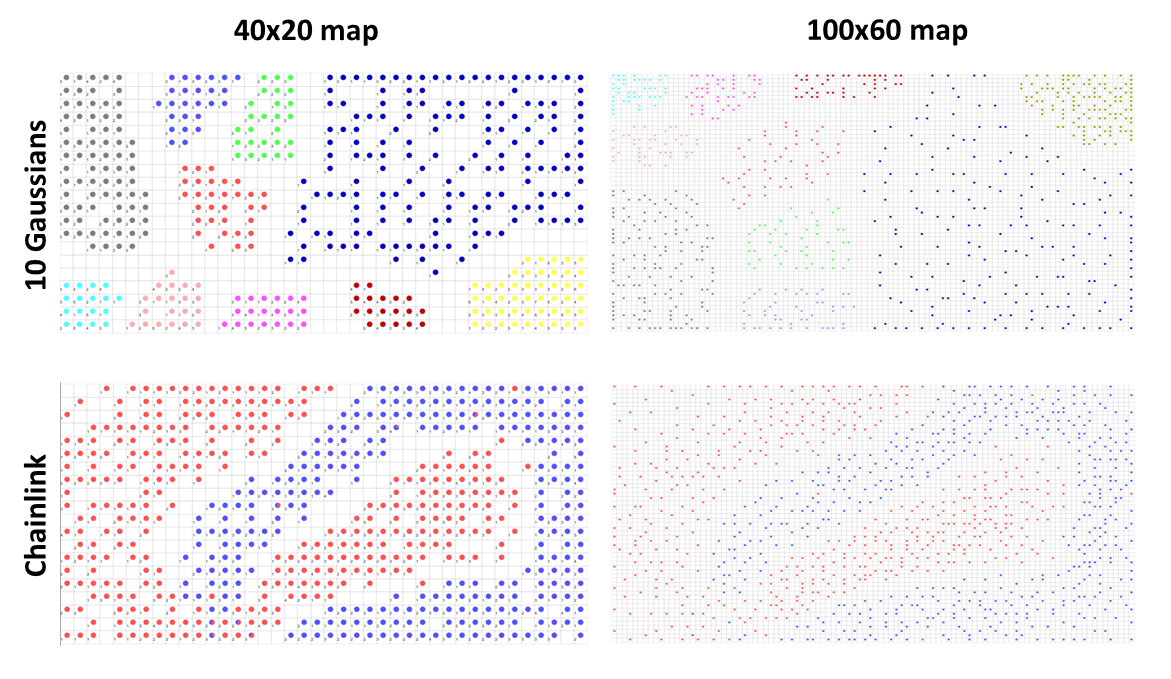

## Comparison against SOM ToolBox

Before starting to explore the visualizations, we validate our implementation against the visualizations produced by Java SOM ToolBox. We use 10 clusters dataset and both small and big maps and create all visualizations using our implementation and the ToolBox.

We use the same parameters for both approaches. <br>
For 40x20 map we use a radius value of 0.04 for both P-Matrix and U\*-Matrix and for 100x60 map we use 0.05. Other visualizations have no parameters.

We see that our implementation produced very similar results to SOM ToolBox (to be precise, we flipped the plots obtained with SOM ToolBox to have easier comparison and same positioning of the clusters). We may add that due to differt color schemes some aspects of the data could be perceived better in SOM ToolBox, e.g. small clusters in D-Matrix of 40x20 SOM (dark blue regions in SOM ToolBox separated by lighter blue borders are much easier perceived as clusters, than in our visualization). However this is an issue of a color mapping and not the implementation itself, especially since we provide a possibility to choose any other matplotlib colormap instead our default "viridis".

Since we did not check every single point of the visualizations, we will not state that the results are identical, but as we did not observe any major differences, we shall consider our implementation as suffient and will use it for the further analysis. 

The comparison of visualizations for Chainlink dataset could be found in appendix. They did not show any additional differences, so we do not include them in this comparison. 

### 10 Gaussians, Small SOM (40x20)

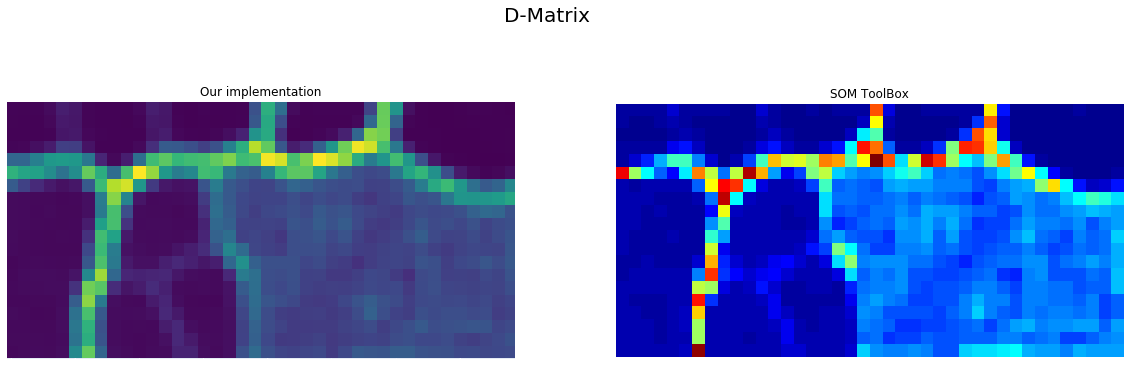

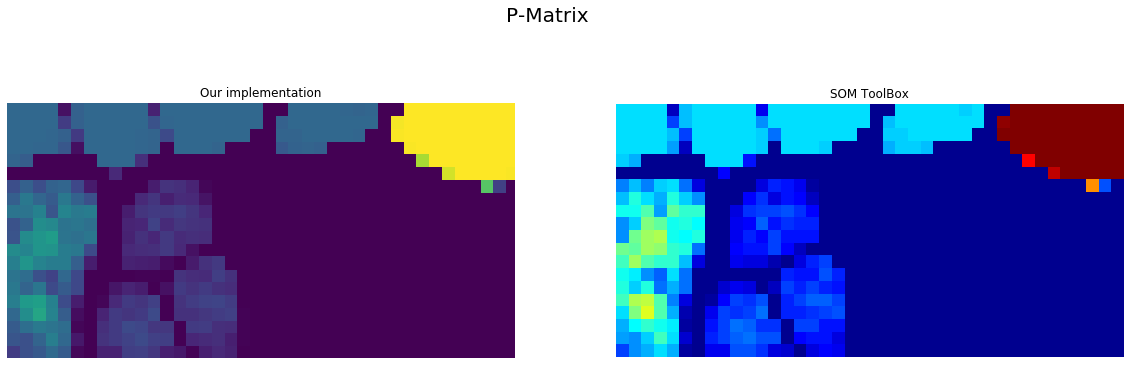

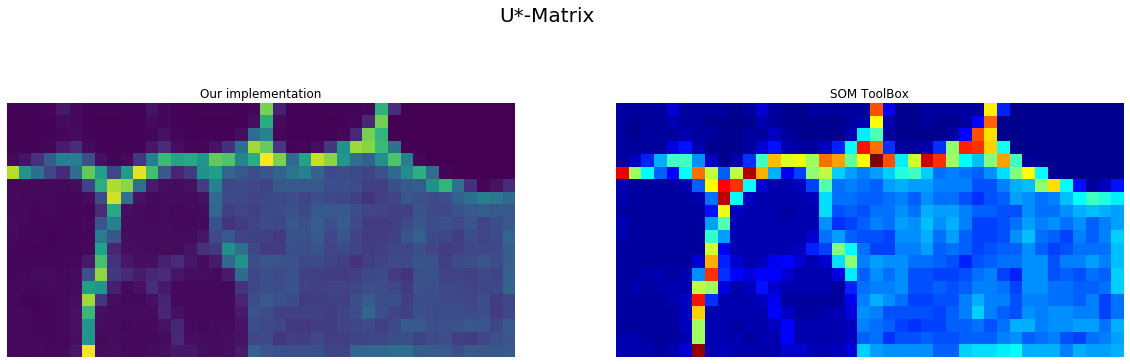

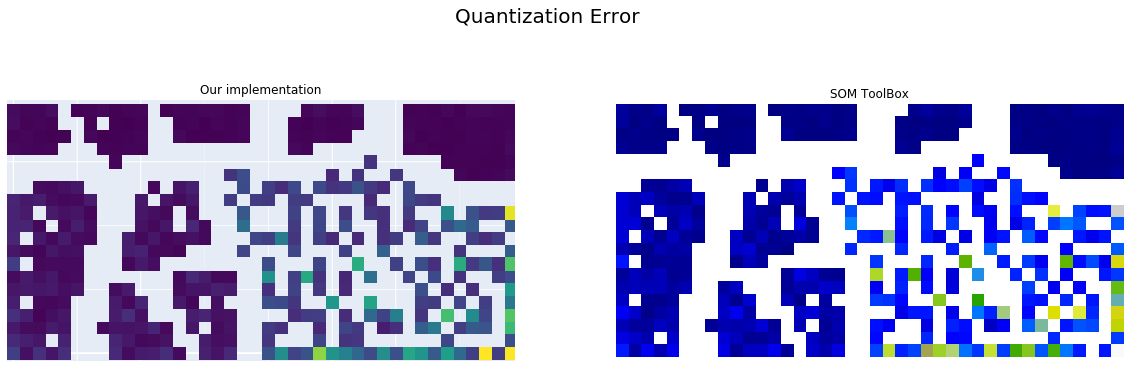

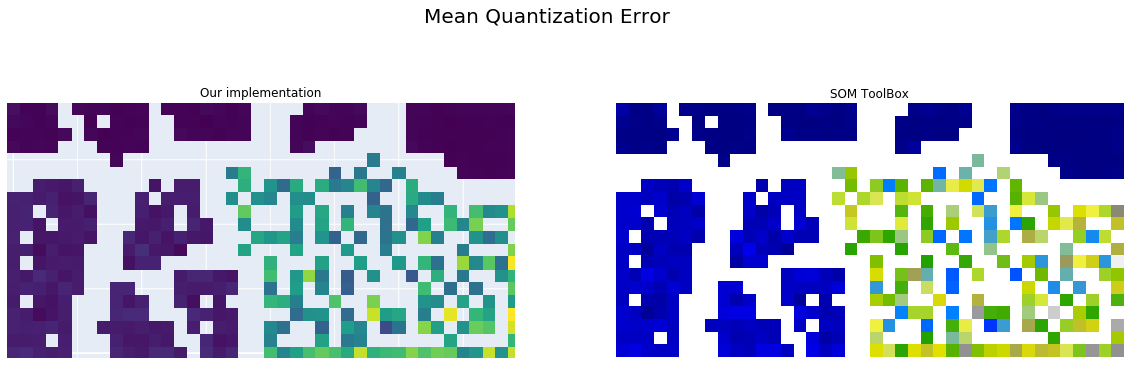

In [19]:
show_plots_comparison_for_SOM("10clusters", "40x20")

### 10 Gaussians, Big SOM (100x60)

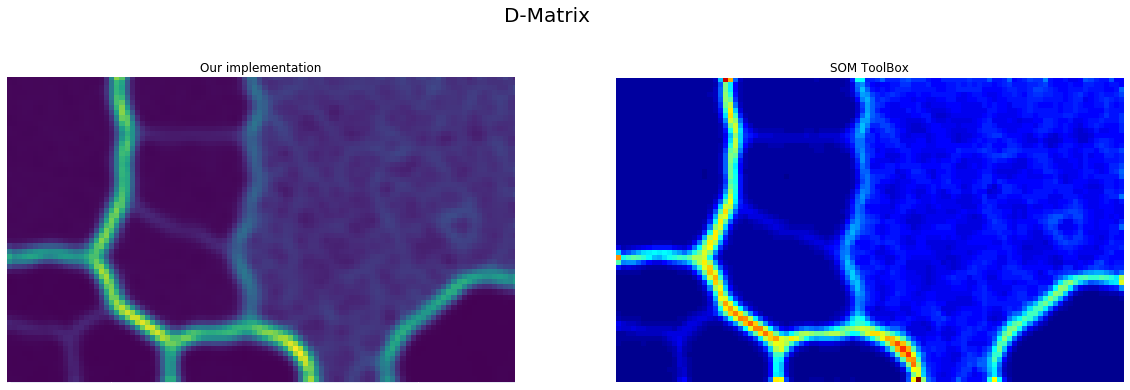

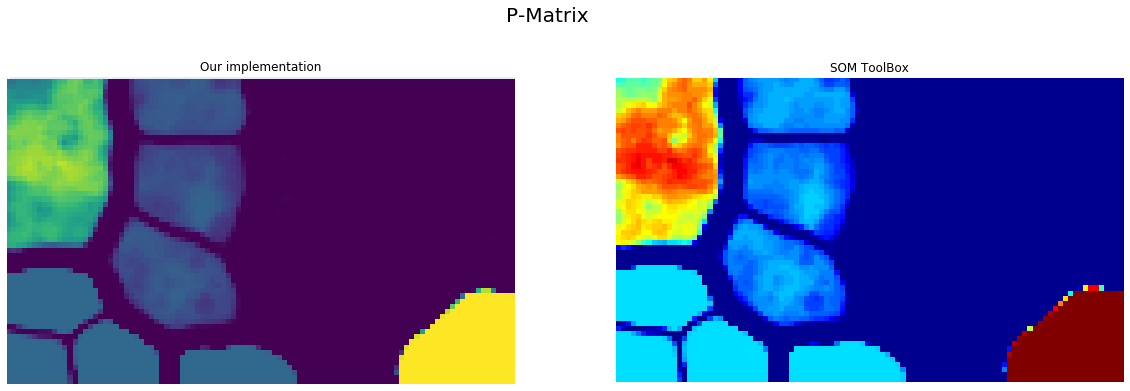

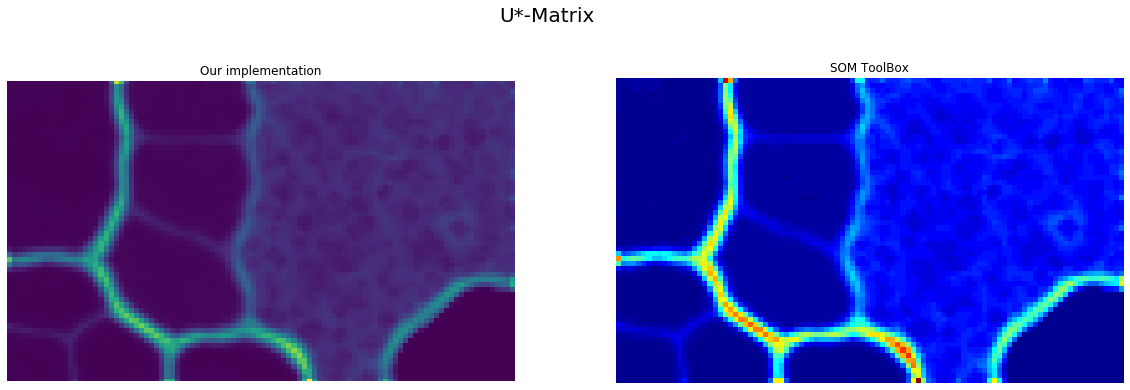

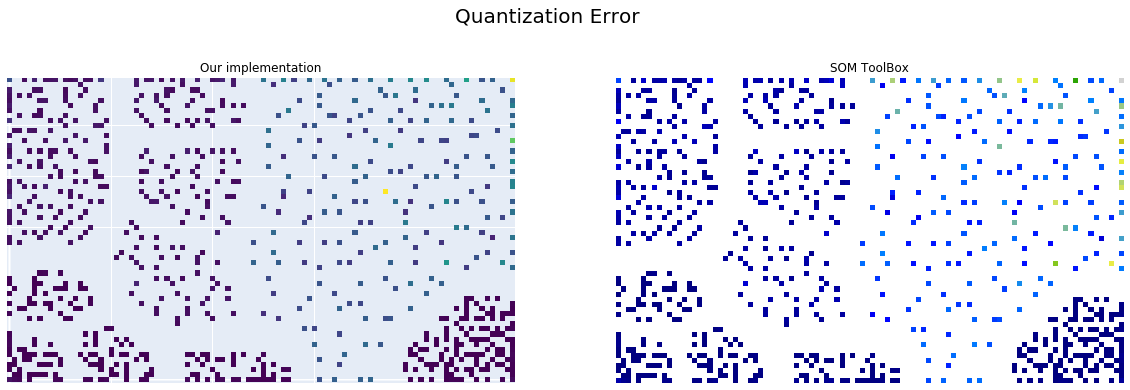

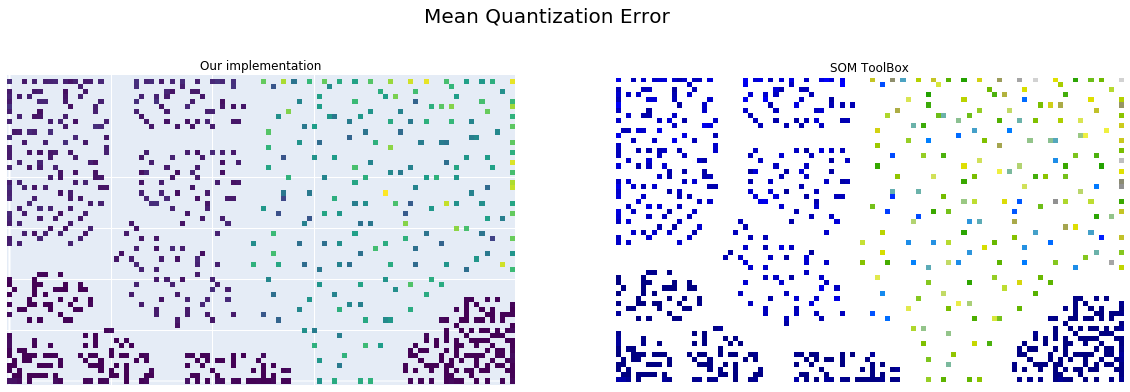

In [20]:
show_plots_comparison_for_SOM("10clusters", "100x60")

## Analysis - 10 Gaussians dataset

As a starting step, we analyze the effect of the parameters for P-Matrix and U\*-Matrix. Other implemented visualizations have no parameters, so we will look at them later. We know the structure of the dataset in advance (10 clusters of different size and density), so with our visualizations we aim at showing the separation between the clusters.

For better overview of the parameters, we plot the P-Matrix for 40x20 SOM and U\*-Matrix for 100x60 (even though using 100x60 map would be more visually appealing for both visualizations, we preferred to demonstrate the effects on the different maps).
We see that in case of P-Matrix the radius is very important for the interpretation of the possible patterns in the data. When using a low radius, e.g. in our case 0.01 only very dense clusters can be detected. On the other hand, when the radius is selected rather high, e.g. in our case 0.1, the clusters located close enough to each other are grouped together and are considered as one big cluster; this effect is seen even more when radius is increased to 0.45, where some cluster could still be separated, but the borders are not so clear anymore. We select the radius 0.04 to be optimal for 40x20 SOM, as in this case the clusters are separated the best.

Slightly different picture is observed for U\*-Matrix. This matrix is known for its ability to separate the clusters well. Indeed, the clusters are could be easily identified for different radius values - 0.01, 0.05 and 0.1 (to make the borders perceptionally more clear we selected other colormap). Although for high radius values, e.g. 0.5 (recall that the initial data was standardized), the smaller clusters are not separated so clear anymore, the smaller clusters still remain visible to some extent. For 100x60 SOM and U\*-Matrix visualization we consider the radius 0.05 to be optimal, even though slightly smaller or larger radius would be fine as well. 


So depending on the need for interpretation of the patterns, P-Matrix with a small radius could be selected, when very "detailed" information has to be identified and missing the "big picture" or overview is not so important, or on the contrary P-Matrix with a bigger radius would be required, if a rather general view on the data is preferred (obviously, several options could and should be tried to have better insights into the data). If the goal is to identify the clusters "as they are", U\*-Matrix shall be used instead.

In [29]:
radius = [0.01, 0.04, 0.1, 0.45]
all_figures=[]

for r in radius:
    fig = clusters10_40x20_vis.plot_p_matrix(r, interp=False)
    fig.layout.update(margin=dict(l=20), title="radius="+str(r), autosize=False, width=400, height=240)
    all_figures.append(fig)

v1=VBox([Label("SOM 40x20, P-Matrix"),HBox(all_figures[0:2]), HBox(all_figures[2:4])])

radius = [0.01, 0.05, 0.1, 0.5]
all_figures=[]

for r in radius:
    fig = clusters10_100x60_vis.plot_u_star_matrix(r, interp=False, color='rainbow')
    fig.layout.update(margin=dict(l=20), title="radius="+str(r), autosize=False, width=400, height=280)
    all_figures.append(fig)

v2=VBox([Label("SOM 100x60, U*-Matrix"),HBox(all_figures[0:2]), HBox(all_figures[2:4])])

display(VBox([v1, v2]))

    'data': [{…

We proceed by looking at all visualizations, first for 40x20 SOM and then for 100x60. As observed in the step below, we shall change the colormap, so that the cluster boarders are perceived easier.

We can see that the clusters are much better separated on 100x60 map with very clear borders in all Matrix visualizations. On the contrary, 40x20 map performed no so well in separating smaller clusters, even though they are visible, still without former knowledge of the structures in the data, it would be more difficult ot judge about clusters. Still both maps failed to detect all 10 clusters, but suggest existence only of 9 clusters.

The existence of the 10 clusters show us quantization error and mean quantization error plots.


In [22]:
visualizations = [
    clusters10_40x20_vis.plot_d_matrix(interp=False, color='rainbow'),
    clusters10_40x20_vis.plot_p_matrix(0.04, interp=False, color='rainbow'),
    clusters10_40x20_vis.plot_u_star_matrix(0.04, interp=False, color='rainbow'),
    clusters10_40x20_vis.plot_quantization_error(interp=False, color='rainbow'),
    clusters10_40x20_vis.plot_mean_quantization_error(interp=False, color='rainbow')
]

for fig in visualizations:
    fig.layout.update(margin=dict(l=20), autosize=False, width=400, height=240)
    fig["layout"]["title"]["text"]=re.sub("10clusters 40x20 ", '', fig["layout"]["title"]["text"])
    
v1=VBox([Label("SOM 40x20"),HBox(visualizations[0:3]), HBox(visualizations[3:5])])

visualizations = [
    clusters10_100x60_vis.plot_d_matrix(interp=False, color='rainbow'),
    clusters10_100x60_vis.plot_p_matrix(0.05, interp=False, color='rainbow'),
    clusters10_100x60_vis.plot_u_star_matrix(0.05, interp=False, color='rainbow'),
    clusters10_100x60_vis.plot_quantization_error(interp=False, color='rainbow'),
    clusters10_100x60_vis.plot_mean_quantization_error(interp=False, color='rainbow')
]

for fig in visualizations:
    fig.layout.update(margin=dict(l=20), autosize=False, width=400, height=280)
    fig["layout"]["title"]["text"]=re.sub("10clusters 100x60 ", '', fig["layout"]["title"]["text"])
    
v2=VBox([Label("SOM 100x60"),HBox(visualizations[0:3]), HBox(visualizations[3:5])])

display(VBox([v1, v2]))

    'data': [{'colorscal…

## Analysis - Chainlink dataset

Similar to 10 Clusters dataset, we first compare the influence of different parameters on P-Matrix and U*-Matrix results.
As chainlink dataset represents two intertwined rings and the data is therefore not separable, we do not observe here clear structures.
We will see further, that these types of visualizations may be not the optimal ones for this dataset.

Still, similarly to 10 clusters case, we observe that proper radius selection may be more informative. For example, P-Matrix with radius of 0.1 or 0.2 would suggest us that there is some data separation in the initial dataset, also we see structures similar to rings. While in case if radius 0.1 the separation seems more clear, the radius 0.2 shows more clearly, where the topology preservation violations appear. The radius of 0.05 or 0.5 is not representative at all in this case.

U\*-Matrix with radius values 0.05, 0.1 and 0.2 displays very well, where the data is separated, however by looking at the visualization without former knowledge about the dataset, it would not be possible to recognize the respective structures. As identified earlier, U\*-Matrix is not so sensitive to the selection of radius (sure, when the considered differences are not too high).

As optimal, for P-Matrix we would consider the radius of 0.2 and for U\*-Matrix the radius of 0.1, however especially in this case this choice remains very subjective.

In [30]:
radius = [0.05, 0.1, 0.2, 0.5]
all_figures=[]

for r in radius:
    fig = chainlink_40x20_vis.plot_p_matrix(r, interp=False)
    fig.layout.update(margin=dict(l=20), title="radius="+str(r), autosize=False, width=400, height=240)
    all_figures.append(fig)

v1=VBox([Label("SOM 40x20, P-Matrix"),HBox(all_figures[0:2]), HBox(all_figures[2:4])])

radius = [0.05, 0.1, 0.2, 0.5]
all_figures=[]

for r in radius:
    fig = chainlink_100x60_vis.plot_u_star_matrix(r, interp=False)
    fig.layout.update(margin=dict(l=20), title="radius="+str(r), autosize=False, width=400, height=280)
    all_figures.append(fig)

v2=VBox([Label("SOM 100x60, U*-Matrix"),HBox(all_figures[0:2]), HBox(all_figures[2:4])])

VBox([v1, v2])

    'data': [{…

We look now at all visualizations for the Chainlink dataset and see that the most visualizations are not very useful in the sense that they do not represent the pattern in the dataset well enough. An exception would be the P-Matrix for 100x60 map, where wee can indeed identify the two ring structures and the position, where both rings intertwine (upper middle with yellowish color).

The quantization errors and mean quitization errors are distributed almost uniformly for the most units of the map and therefore not so meaningful for interpretation (however from 40x20 maps we can identify the borders quite well).

Here the selection of a proper colomap shall be emphasized again - looking at the plots produced by SOM ToolBox (see Appendix), we can confirm that P-Matrix is most representative, but the used colors support easier interpretation of the data.

In [24]:
visualizations = [
    chainlink_40x20_vis.plot_d_matrix(interp=False),
    chainlink_40x20_vis.plot_p_matrix(0.2, interp=False),
    chainlink_40x20_vis.plot_u_star_matrix(0.1, interp=False),
    chainlink_40x20_vis.plot_quantization_error(interp=False),
    chainlink_40x20_vis.plot_mean_quantization_error(interp=False)
]

for fig in visualizations:
    fig.layout.update(margin=dict(l=20), autosize=False, width=400, height=240)
    fig["layout"]["title"]["text"]=re.sub("chainlink 40x20 ", '', fig["layout"]["title"]["text"])
    
v1=VBox([Label("SOM 40x20"),HBox(visualizations[0:3]), HBox(visualizations[3:5])])

visualizations = [
    chainlink_100x60_vis.plot_d_matrix(interp=False),
    chainlink_100x60_vis.plot_p_matrix(0.1, interp=False),
    chainlink_100x60_vis.plot_u_star_matrix(0.05, interp=False),
    chainlink_100x60_vis.plot_quantization_error(interp=False),
    chainlink_100x60_vis.plot_mean_quantization_error(interp=False)
]

for fig in visualizations:
    fig.layout.update(margin=dict(l=20), autosize=False, width=400, height=280)
    fig["layout"]["title"]["text"]=re.sub("chainlink 100x60 ", '', fig["layout"]["title"]["text"])
    
v2=VBox([Label("SOM 100x60"),HBox(visualizations[0:3]), HBox(visualizations[3:5])])

VBox([v1, v2])

    'data': [{'colorscal…

## Conclusion

We implemented and analyzed 5 different visualizations for Self-Organizing Maps. We can conclude that for every dataset different visualization types and with properly selected parameters would be helpful to detect the structures in the original data. Moreover, a careful selection of colors is also necessary for appropriate visual representations, that are comfortable for the human eyes to perceive. Finally, the best approach would be to try different possibilities to get a qualitative general view on the data, but still not missing potentially important details.

<style>
@media print
{
h1 {page-break-before:always}
}
</style>



# Appendix: Comparison of visualizations for Chainlink dataset

### Small SOM (40x20)

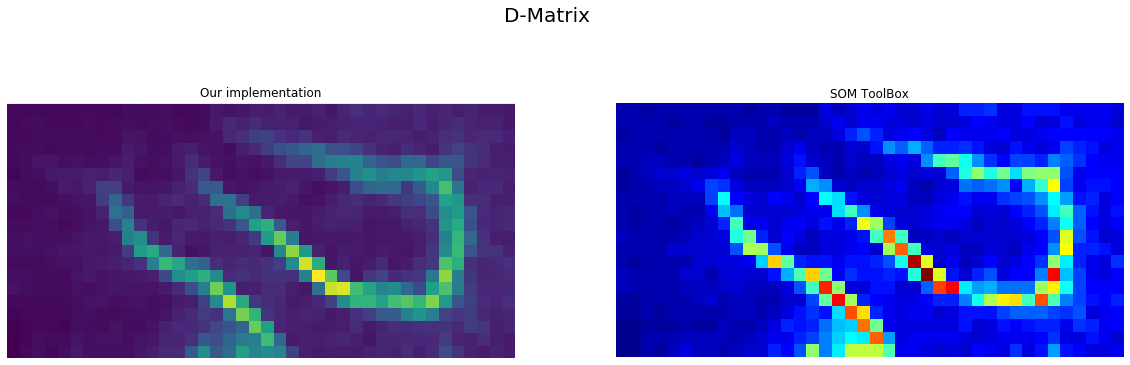

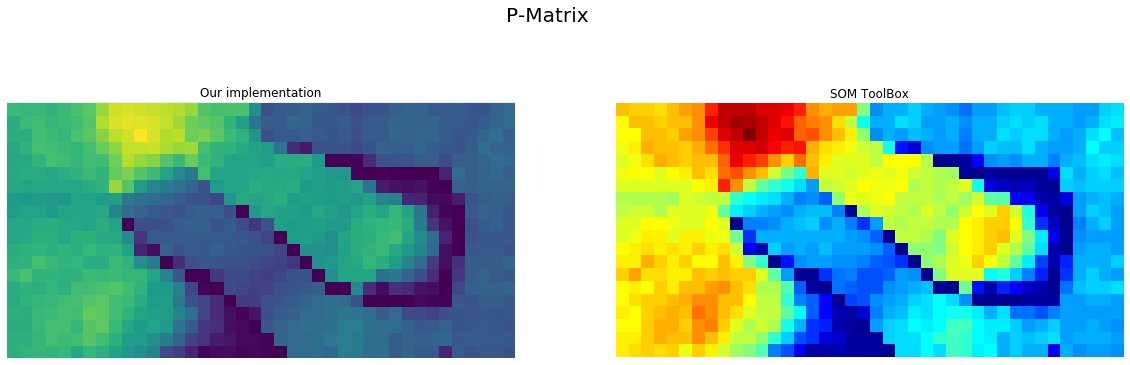

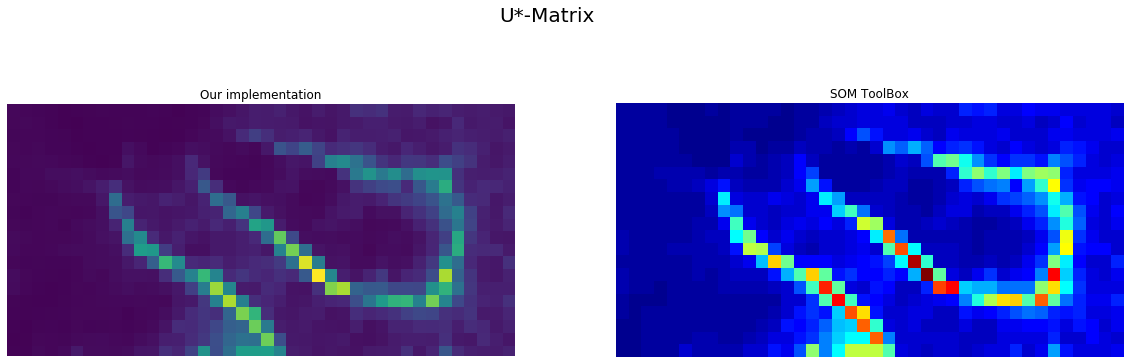

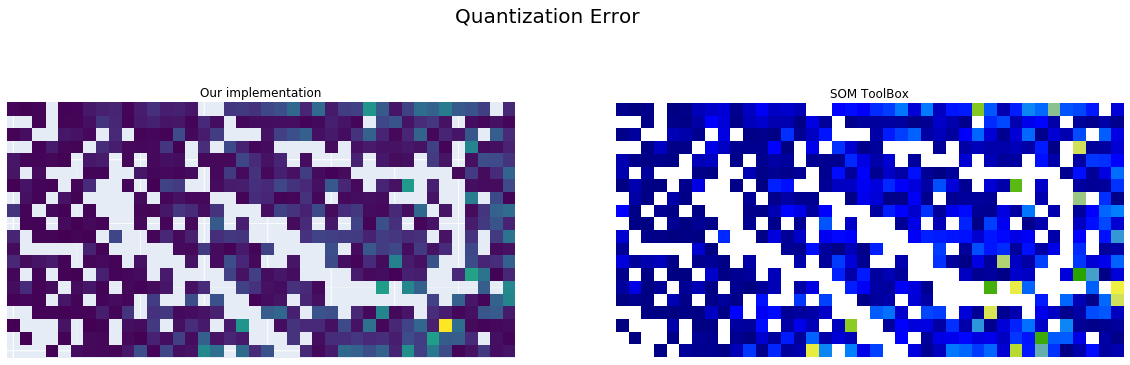

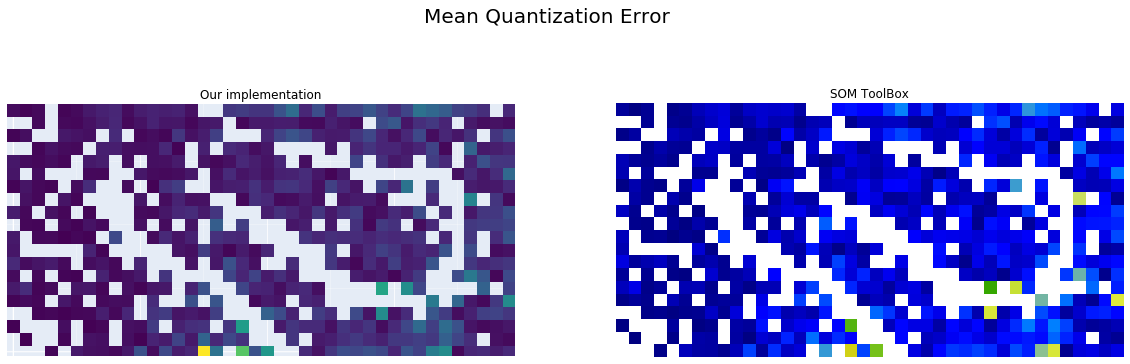

In [25]:
show_plots_comparison_for_SOM("chainlink", "40x20")

### Big SOM (100x60)

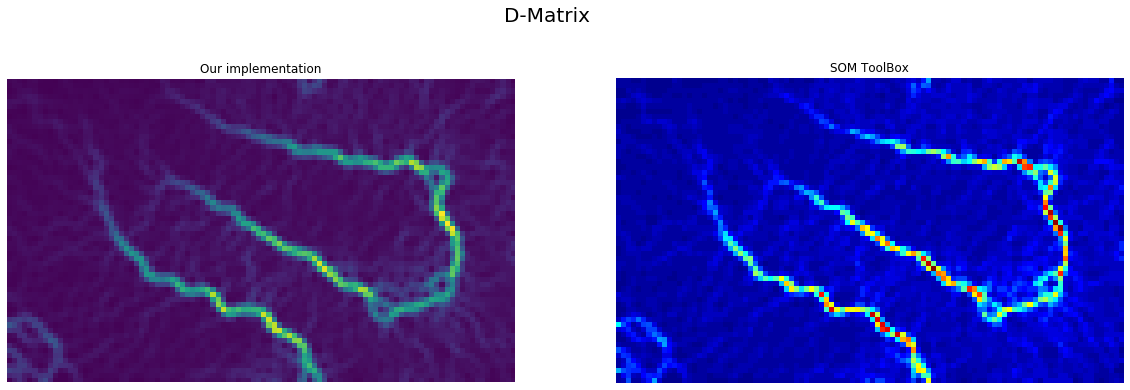

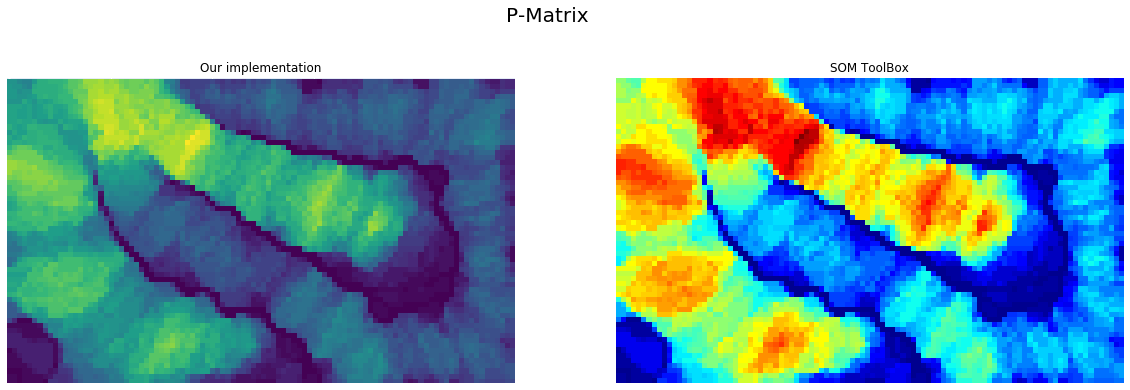

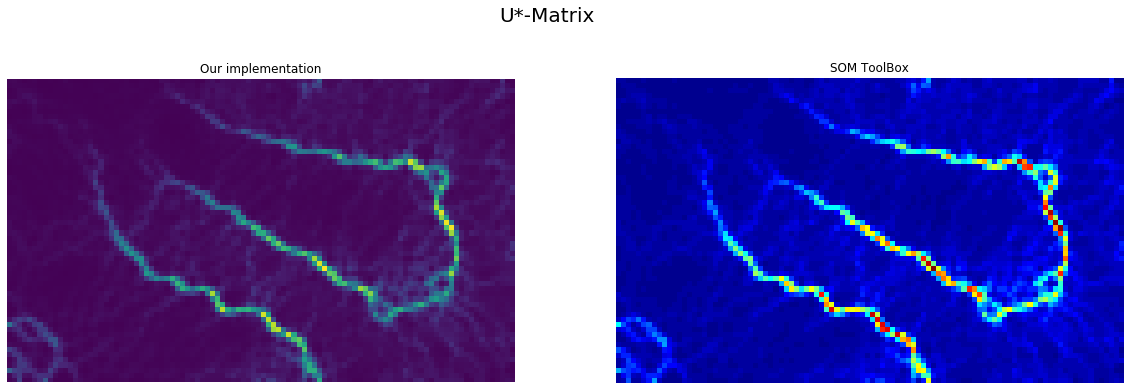

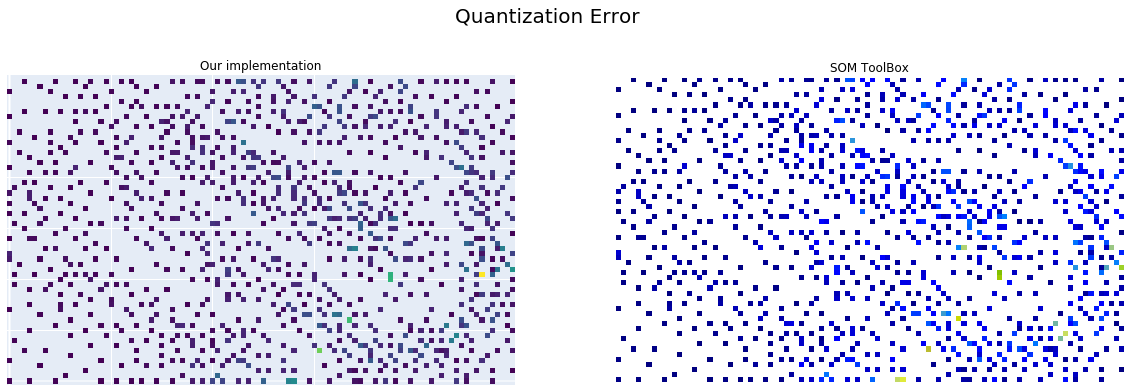

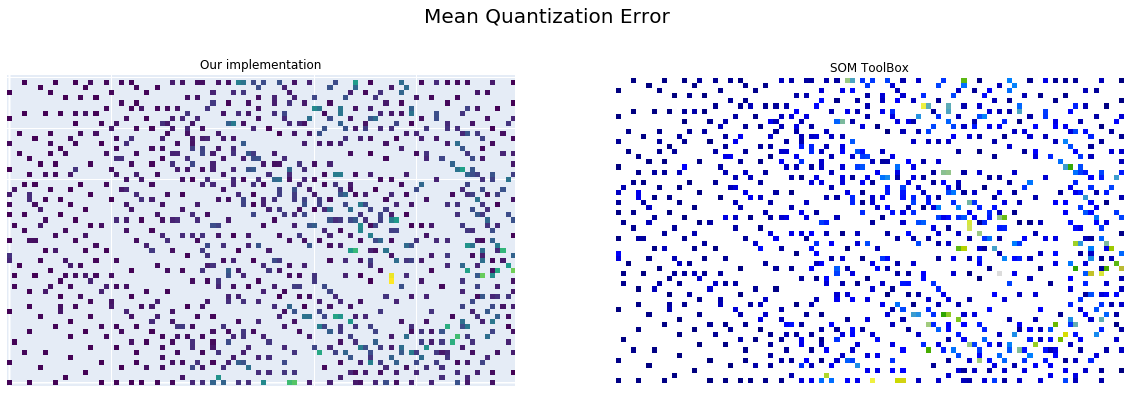

In [26]:
show_plots_comparison_for_SOM("chainlink", "100x60")